# Code for gaussian benchmark baselines

## 1. Imports

In [1]:
import math
import gc
import wandb
import numpy as np

from matplotlib import pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import os, sys
sys.path.append("..")

import torch
from torch import nn

from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

# from torch.distributions.mixture_same_family import MixtureSameFamily
# from torch.distributions.categorical import Categorical
# from torch.distributions.multivariate_normal import MultivariateNormal

from sklearn.decomposition import PCA
# from scipy.stats import ortho_group
# from scipy.linalg import sqrtm, inv
from sklearn.decomposition import PCA

# from scipy.special import gamma
from src.gaussian_benchmark import GaussianBenchmark, get_gaussian_benchmark
from src.metrics import MMD

In [2]:
gc.collect(); torch.cuda.empty_cache()

## 2. Config

In [3]:
DIM = 16
EPS = 10
assert DIM > 1

L1 = 1e-10
GPU_DEVICE = 1
EPSILON = EPS

SEED = 42
MAX_STEPS = 1000
CONTINUE = -1

In [4]:
EXP_NAME = f'Gaussians_identity_baseline_EPSILON_{EPSILON}_DIM_{DIM}'

config = dict(
    DIM=DIM,
    EPSILON=EPSILON,
    SEED=SEED,
    MAX_STEPS=MAX_STEPS,
)

In [5]:
assert torch.cuda.is_available()
torch.cuda.set_device(GPU_DEVICE)

## 3. Initialize Benchmark

In [6]:
torch.manual_seed(SEED); np.random.seed(SEED);
benchmark = get_gaussian_benchmark(DIM, EPS, f"cuda:{GPU_DEVICE}", download=False)

X_sampler = benchmark.X_sampler
Y_sampler = benchmark.Y_sampler

In [7]:
pca = PCA(n_components=2)

samples, labels = X_sampler.sample(10000)
samples = samples.cpu()

target_samples, target_labels = Y_sampler.sample(10000)
target_samples = target_samples.cpu()

pca.fit(torch.cat((samples, target_samples)))

PCA(n_components=2)

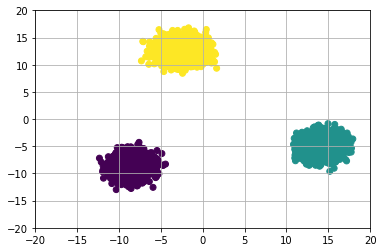

In [8]:
samples_pca = pca.transform(samples)

plt.scatter(samples_pca[:, 0], samples_pca[:, 1], c=labels)
plt.xlim(-20, 20)
plt.ylim(-20, 20)
plt.grid()

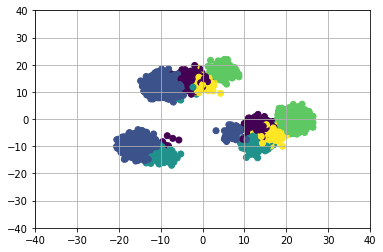

In [9]:
target_samples_pca = pca.transform(target_samples)
plt.scatter(target_samples_pca[:, 0], target_samples_pca[:, 1], c=target_labels)
plt.xlim(-40, 40)
plt.ylim(-40, 40)
plt.grid()

## 4. Model initialization

In [10]:
class IdentityBaseline(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

In [11]:
model = IdentityBaseline()

## 5. Training

In [12]:
wandb.init(name=EXP_NAME, config=config, project='SchrodingerBridge')

wandb: Currently logged in as: schrodinger_bridge (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.13.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


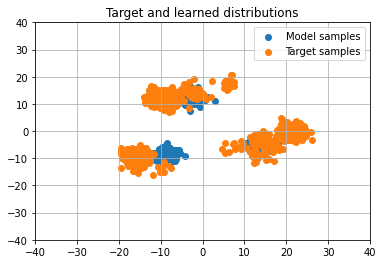

100%|██████████| 1000/1000 [01:01<00:00, 16.37it/s]


In [13]:
# metrics = []
torch.manual_seed(SEED); np.random.seed(SEED)

X = X_sampler.sample(1000)[0]
Y = Y_sampler.sample(1000)[0]
norm_mmd = MMD(X, Y, kernel="rbf", device=f"cuda:{GPU_DEVICE}", scale_factor=DIM)
wandb.log({f'norm_mmd' : norm_mmd}, step=0)

for step in tqdm(range(CONTINUE + 1, MAX_STEPS)):
    model.train()
    
    if step % 100 == 0:
        model.eval()
        X = X_sampler.sample(1000)[0]
        Y = Y_sampler.sample(1000)[0]
        
        XN = model(X)
        
        Y_pca = pca.transform(Y.cpu())
        XN_pca = pca.transform(XN.detach().cpu())
        
        clear_output(wait=True)
        plt.scatter(XN_pca[:, 0], XN_pca[:, 1], label="Model samples")
        plt.scatter(Y_pca[:, 0], Y_pca[:, 1], label="Target samples")
        plt.legend()
        plt.grid()
        plt.title("Target and learned distributions")
        plt.xlim(-40, 40)
        plt.ylim(-40, 40)
        plt.show()

        mmd = MMD(Y, XN, kernel="rbf", device="cuda", scale_factor=DIM)/norm_mmd
        wandb.log({f'MMD_model_target' : mmd}, step=step)
        
        Y = Y_sampler.sample(1000)[0]
        Y_prime = Y_sampler.sample(1000)[0]

        mmd = MMD(Y, Y_prime, kernel="rbf", device="cuda", scale_factor=DIM)/norm_mmd
        wandb.log({f'Y_sampler_mmd' : mmd}, step=step)

    gc.collect(); torch.cuda.empty_cache()